In [1]:
import pandas
#from numpy.core.numeric import infty
!pip install numpy
!pip install pandas
!pip install plotly
!pip install scikit-learn 
!pip install matplotlib

# scikit-learn = non-depreceated sklearn

TASK 1

In [2]:
import pandas as pd
# read the csv and make it a pandas.DataFrame
frame = pd.DataFrame(pd.read_csv("./blood_transfusion.csv"))
frame.describe(include='all') # 5 columns, 4 numerical, class is nominal (1 or 0)

,months_since_last_donation,total_number_of_donations,total_blood_donated,months_since_first_donation,class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [3]:
import plotly.express as px

"""fig = px.histogram(frame.loc[frame['class'] == 1].Margin, x="Margin", title="Histogram of Margin with Severity = 1")
fig.show()"""

#2.3
# A pie-chart showing how many cases of each class exist
fig = px.pie(frame, values='months_since_last_donation', names='class', title='% of classes')
fig.show()
# Duidelijk verschil tussen het percentage 0 en 1 wanneer mensen een kortere periode hebben sinds laatste donatie
fig = px.histogram(frame, x='months_since_last_donation',  color='class', title='')
fig.show()
# percentage redelijk gelijk over alle data
fig = px.histogram(frame, x='months_since_first_donation',  color='class', title='')
fig.show()
# Meer donations is gelijk aan hoger percentage class 1
fig = px.histogram(frame, x='total_number_of_donations',  color='class', title='')
fig.show()
fig = px.scatter(frame, x='months_since_last_donation', y="total_number_of_donations", color='class', title='')
fig.show()
fig = px.scatter(frame, x='months_since_last_donation', y="total_number_of_donations", color='class', title='')
fig.show()
fig = px.histogram(frame, x='total_blood_donated',  color='class', title='')
fig.show()
fig = px.scatter(frame, x='months_since_last_donation', y="months_since_first_donation", color='class', title='')
fig.show()

# total blood donated is linear with number of donations: dus wss niet nodig om beide te hebben in een vergelijking
fig = px.scatter(frame, x='total_blood_donated', y="total_number_of_donations", color='class', title='')
fig.show()
fig = px.scatter_3d(frame, x="months_since_last_donation", y="total_blood_donated", z='total_number_of_donations', color="class", title="3d scatter")
fig.show()

# Months since last donation is belangrijkst, spreid het meeste data, gevolgd door total blood donated. Miss een importance checker hier
fig = px.scatter_3d(frame, x="months_since_last_donation", y="total_blood_donated", z='months_since_first_donation', color="class", title="3d scatter")
fig.show()

fig = px.scatter(frame, x='months_since_last_donation', y='months_since_first_donation', color='class', title="scatter")
fig.show()

fig = px.scatter(frame, x='months_since_first_donation', y='months_since_last_donation', color='class', title="scatter")
fig.show()
fig = px.histogram(frame, x='months_since_last_donation', color='class', title='')
fig.show()

TASK 2

In [4]:
preprocessed = frame.copy() 
preprocessed = (preprocessed-preprocessed.min())/(preprocessed.max()-preprocessed.min()) # Normalization
# It also normalizes the class, but because class is either 1 or 0, the formula does not change the class 
preprocessed.describe()

,months_since_last_donation,total_number_of_donations,total_blood_donated,months_since_first_donation,class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,0.128469,0.092137,0.092137,0.336272,0.237968
std,0.109397,0.119170,0.119170,0.253924,0.426124
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.037162,0.020408,0.020408,0.145833,0.000000
50%,0.094595,0.061224,0.061224,0.270833,0.000000
75%,0.189189,0.122449,0.122449,0.500000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


TASK 3

In [5]:
from sklearn.model_selection import train_test_split
X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(
    preprocessed.drop('class', axis=1), preprocessed['class'], train_size=0.33, test_size=0.33, random_state=1) # small train_size
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(
    preprocessed.drop('class', axis=1), preprocessed['class'], train_size=0.66, test_size=0.33, random_state=1) # large train_size
# random state for reproducibility

Elapsed time to compute the importances: 0.038 seconds


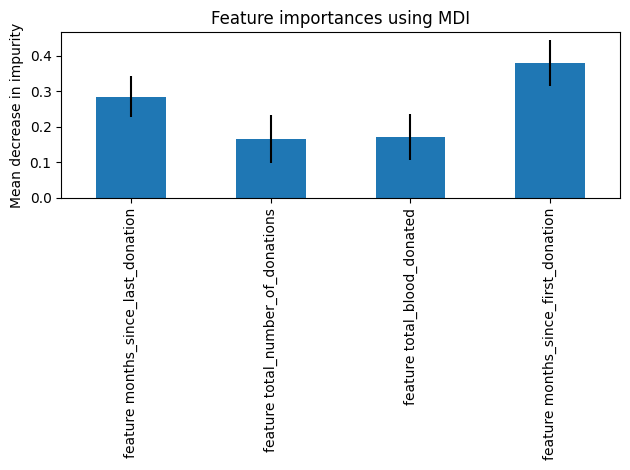

In [6]:
""""NIET MET DE OPDRACHT TE MAKEN, FEATURE IMPORTANCE VOOR DE PRESENTATIE"""

import pandas as pd


from sklearn.ensemble import RandomForestClassifier
names = (list(X_train_s))
feature_names = [f"feature {names[i]}" for i in range(X_train_s.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_s, Y_train_s)
import time
import matplotlib.pyplot as plt
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

TASK 4 & 5

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score

#5.1 Confusion matrix
def confusionmatrix(predicted_y, real_y): # it works, im confused :) \j
    """
    This function calculates and prints the confusion matrix.
    :param predicted_y: list: predicted classes for the test data 
    :param real_y: list: real classes of the test data
    :return: prints the normalized confusion matrix, returns nothing
    """
    tp, fp, tn, fn = 0, 0, 0, 0
    for index,_ in enumerate(predicted_y):
        if predicted_y[index][0] == 1: 
            if predicted_y[index] == real_y[index]: 
                tp += 1
            else:
                fp += 1
        elif predicted_y[index][0] == 0:
            if predicted_y[index] == real_y[index]: 
                tn += 1
            else:
                fn += 1
        #normalize
    tp = tp / len(predicted_y) * 100
    fp = fp / len(predicted_y) * 100
    tn = tn / len(predicted_y) * 100
    fn = fn / len(predicted_y) * 100
    print(f"\t P \t\t N \n T \t {tp:.2f} \t\t {tn:.2f} \n F \t {fp:.2f} \t\t {fn:.2f} \n")

def accuracy_checker(X_test, y_test, pred, mode="basic"):
    """
    This function checks the accuracy of the predicted classes against the real classes.
    :param X_test: pandas.DataFrame: the test data to be classified
    :param y_test: pandas.Series: the real classes of the test data
    :param pred: predictor class: the method used to classify the test data
    :param mode: string: way to evaluate the results
    :return: prints the results, returns nothing
    """
    num, total = 0, 0
    predicted, true = [], []
    for index, row in X_test.iterrows():
        p = pred.predict(X_test.loc[[index]])
        q = list(y_test.loc[[index]])
        if p == q:
            num += 1
        total += 1
        predicted.append(p)
        true.append(q)
    if mode == "basic":
        print(f"Accuracy: {num/total*100:.2f}%")
    elif mode == "classification_report":
        print(classification_report(true, predicted))
    elif mode == "classification_report_dict":
        return classification_report(true, predicted, output_dict=True)
    elif mode == "confusion_matrix":
        confusionmatrix(predicted, true)
    elif mode == "fbeta":
        print("average=macro:", fbeta_score(true, predicted, average='macro', beta=0.5))
        print("average=weighted:", fbeta_score(true, predicted, average='weighted', beta=0.5))
        print("average=None:", fbeta_score(true, predicted, average=None, beta=0.5))
    else:
        return num/total*100

# 4.1 KNN
class KNN:    
    def __init__(self, k=5):
        """
        initializes an instance of the KNN class
        :param k: int: number of neighbors
        """
        self.k = k
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        """
        fits the KNN class
        :param X: pandas.DataFrame: the train data
        :param y: pandas.Series: the classes of the train data
        :return: a fitted instance of the KNN class
        """
        self.X_train = X
        self.y_train = y
        return self
    
    def euclidean_distance(self, a, b):
        """
        This function calculates the euclidean distance between two datapoints.
        :param a: list: the first datapoint
        :param b: list: the second datapoint
        :return: float: the euclidean distance between the datapoints
        """
        distance = 0
        for index, _ in enumerate(a):
            distance += (a[index] - b[index]) ** 2
        distance = distance**0.5
        return distance    
    
    def predict(self, X_test):
        """
        predicts the class of the test data
        :param X_test: pandas.DataFrame: the test data
        :return: list: the predicted classes
        """
        test_y = list([0 for _ in range(X_test.shape[0])])
        for index, (_,test_row) in enumerate(X_test.iterrows()):
            distances = []
            for _, train_row in self.X_train.iterrows():
                test_values = list(test_row)  
                train_values = list(train_row)
                distance = self.euclidean_distance(test_values, train_values)
                distances.append(distance)
            nearest_neighbours = sorted(range(len(distances)), key=lambda i: distances[i])[:self.k]
            neighbor_labels = self.y_train.iloc[nearest_neighbours]
            predicted_label = round(neighbor_labels.mean())
            test_y[index] = predicted_label
        return test_y

# from accuracy it appears that k=5 is best for small set and k=[2,4,9] are all best for large set, for 1<=k<=9
knn_s = KNN(5)
knn_s.fit(X_train_s, Y_train_s)
knn_s_acc = accuracy_checker(X_test_s, Y_test_s, knn_s, "return")
knn_l = KNN(5)
knn_l.fit(X_train_l, Y_train_l)
knn_l_acc = accuracy_checker(X_test_l, Y_test_l, knn_l, "return")

# 4.2 nbc
from sklearn.naive_bayes import GaussianNB
nbc_s = GaussianNB()
nbc_s.fit(X_train_s, Y_train_s)
nbc_s_acc = accuracy_checker(X_test_s, Y_test_s, nbc_s, "return")
nbc_l = GaussianNB()
nbc_l.fit(X_train_l, Y_train_l)
nbc_l_acc = accuracy_checker(X_test_l, Y_test_l, nbc_l, "return")

# 4.3 svc
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
svc_s = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_s.fit(X_train_s, Y_train_s)
svc_s_acc = accuracy_checker(X_test_s, Y_test_s, svc_s, "return")
svc_l = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_l.fit(X_train_l, Y_train_l)
svc_l_acc = accuracy_checker(X_test_l, Y_test_l, svc_l, "return")

# 4.4 mlp
from sklearn.neural_network import MLPClassifier
mlp_s = MLPClassifier(random_state=1, max_iter=400).fit(X_train_s, Y_train_s)
mlp_s_acc = accuracy_checker(X_test_s, Y_test_s, mlp_s, "return")
mlp_l = MLPClassifier(random_state=1, max_iter=400).fit(X_train_l, Y_train_l)
mlp_l_acc = accuracy_checker(X_test_l, Y_test_l, mlp_l, "return")

classifiers_list = ["knn_s", "knn_l", "nbc_s", "nbc_l", "svc_s", "svc_l", "mlp_s", "mlp_l"]
accuracy_list = [knn_s_acc, knn_l_acc, nbc_s_acc, nbc_l_acc, svc_s_acc, svc_l_acc, mlp_s_acc, mlp_l_acc]
fig = px.histogram(x=classifiers_list, y=accuracy_list, barmode='group', height=500, title='Classifiers and accuracy', text_auto=True)
fig.update_yaxes(title_text='% Accurate')
fig.update_xaxes(title_text='')
fig.show()


In [8]:
classifiers = [knn_s, knn_l, nbc_s, nbc_l, svc_s, svc_l, mlp_s, mlp_l]
modes = ["confusion_matrix", "classification_report", "fbeta"]
for mode in modes:
    for classifier in classifiers:
        pred_string = ""
        if classifier == svc_s: pred_string = "svc_s"
        elif classifier == svc_l: pred_string = "svc_l"
        elif classifier == mlp_s: pred_string = "mlp_s"
        elif classifier == mlp_l: pred_string = "mlp_l"
        elif classifier == nbc_s: pred_string = "nbc_s"
        elif classifier == nbc_l: pred_string = "nbc_l"
        elif classifier == knn_s: pred_string = "knn_s"
        elif classifier == knn_l: pred_string = "knn_l"
        if pred_string[4] == "s":
            print(f"{mode} for {pred_string}")
            accuracy_checker(X_test_s, Y_test_s, classifier, mode=mode)    
        elif pred_string[4] == "l":
            print(f"\n{mode} for {pred_string}")
            accuracy_checker(X_test_l, Y_test_l, classifier, mode=mode)
        print("-----------------------------------------")

confusion_matrix for knn_s
	 P 		 N 
 T 	 6.48 		 70.04 
 F 	 4.45 		 19.03 

-----------------------------------------

confusion_matrix for knn_l
	 P 		 N 
 T 	 8.10 		 70.45 
 F 	 4.05 		 17.41 

-----------------------------------------
confusion_matrix for nbc_s
	 P 		 N 
 T 	 4.05 		 69.64 
 F 	 4.86 		 21.46 

-----------------------------------------

confusion_matrix for nbc_l
	 P 		 N 
 T 	 3.24 		 71.66 
 F 	 2.83 		 22.27 

-----------------------------------------
confusion_matrix for svc_s
	 P 		 N 
 T 	 1.62 		 73.68 
 F 	 0.81 		 23.89 

-----------------------------------------

confusion_matrix for svc_l
	 P 		 N 
 T 	 2.02 		 74.09 
 F 	 0.40 		 23.48 

-----------------------------------------
confusion_matrix for mlp_s
	 P 		 N 
 T 	 2.83 		 73.28 
 F 	 1.21 		 22.67 

-----------------------------------------

confusion_matrix for mlp_l
	 P 		 N 
 T 	 2.02 		 74.09 
 F 	 0.40 		 23.48 

-----------------------------------------
classification_report for knn_s
    

In [9]:
import plotly.graph_objects as go
from plotly.colors import n_colors
#visualize
metrics_data = {
    'Classifier': ['knn (s)', 'knn (l)', 'nbc (s)', 'nbc (l)', 'svc (s)', 'svc (l)', 'mlp (s)', 'mlp (l)'], 
    'Precision': [59, 67, 45, 53, 67, 83, 70, 83], 
    'Recall' : [25, 32, 16, 13, 6, 8, 11, 8],
    'weighted_fbeta' : [0.72, 0.76, 0.68, 0.68, 0.65, 0.67, 0.68, 0.67],
    'macro_fbeta' : [0.64, 0.69, 0.56, 0.56, 0.51, 0.54, 0.57, 0.54],
    'fbeta_0' : [0.81, 0.83, 0.79, 0.80, 0.79, 0.80, 0.80, 0.80],
    'fbeta_1' : [0.47, 0.55, 0.33, 0.33, 0.23, 0.29, 0.34, 0.29]}
metrics = pd.DataFrame(metrics_data)

# Confusion matrix
confusion = pandas.DataFrame({
    'Classifier': ['knn (s)', 'knn (l)', 'nbc (s)', 'nbc (l)', 'svc (s)', 'svc (l)', 'mlp (s)', 'mlp (l)'],
    'TP': [6.48, 8.1, 4.05, 3.24, 1.62, 2.02, 2.83, 2.02],
    'TN': [70.04, 70.45, 69.64, 71.66, 73.68, 74.09, 73.28, 76.11],
    'FP': [4.45, 4.04, 4.86, 2.83, 0.81, 0.4, 1.21, 0.4],
    'FN': [19.03, 17.41, 21.46, 22.27, 23.89, 23.48, 22.67, 23.48]
})
confused = confusion.copy()
confused.TP = confusion.TP.astype(int)
confused.FP = confusion.FP.astype(int)
confused.TN = confusion.TN.astype(int)
confused.FN = confusion.FN.astype(int)
colorsTP = n_colors('rgb(0, 0, 200)', 'rgb(200, 0, 0)', 10, colortype='rgb')
colorsTN = n_colors('rgb(0, 0, 200)', 'rgb(200, 0, 0)', 80, colortype='rgb')
colorsFP = n_colors('rgb(0, 0, 200)', 'rgb(200, 0, 0)', 10, colortype='rgb')
colorsFN = n_colors('rgb(0, 0, 200)', 'rgb(200, 0, 0)', 30, colortype='rgb')
fig = go.Figure(data=[go.Table(
    header=dict(values=list(confusion.columns),
    align='center'),
    cells=dict(values=[confusion.Classifier, confusion.TP, confusion.TN, confusion.FP, confusion.FN],
    line_color=['rgb(45, 45, 45)', np.array(colorsTP)[confused.TP], np.array(colorsTN)[confused.TN], np.array(colorsFP)[confused.FP], np.array(colorsFN)[confused.FN]],
    fill_color=['rgb(45, 45, 45)',np.array(colorsTP)[confused.TP], np.array(colorsTN)[confused.TN], np.array(colorsFP)[confused.FP], np.array(colorsFN)[confused.FN]],
    align='right'))
])
fig.show()

colorsP = n_colors('rgb(0, 0, 200)', 'rgb(200, 0, 0)', 100, colortype='rgb')
colorsR = n_colors('rgb(0, 0, 200)', 'rgb(200, 0, 0)', 40, colortype='rgb')
fig = go.Figure(data=[go.Table(
    header=dict(values=list(metrics.columns[0:3]),
    align='center'),
    cells=dict(values=[metrics.Classifier, metrics.Precision, metrics.Recall],
    line_color=['rgb(45, 45, 45)',np.array(colorsP)[metrics.Precision], np.array(colorsR)[metrics.Recall]],
    fill_color=['rgb(45, 45, 45)',np.array(colorsP)[metrics.Precision], np.array(colorsR)[metrics.Recall]],
    align='right'))
])
fig.show()

# Fbeta scores
fig = px.histogram(metrics, x='Classifier', y='fbeta_1', barmode='group', height=500, title='fbeta')
fig.update_layout(title_text='F-beta (class 1)')
fig.update_yaxes(title_text='F-0.5 score', range=[0, 1])
fig.show()

# Classification report

classifiers = ['knn (s)', 'knn (l)', 'nbc (s)', 'nbc (l)', 'svc (s)', 'svc (l)', 'mlp (s)', 'mlp (l)']
reportknns = pd.DataFrame(accuracy_checker(X_test_s, Y_test_s, knn_s, mode="classification_report_dict"))
reportknnl = pd.DataFrame(accuracy_checker(X_test_l, Y_test_l, knn_l, mode="classification_report_dict"))
reportnbcs = pd.DataFrame(accuracy_checker(X_test_s, Y_test_s, nbc_s, mode="classification_report_dict"))
reportnbcl = pd.DataFrame(accuracy_checker(X_test_l, Y_test_l, nbc_l, mode="classification_report_dict"))
reportsvcs = pd.DataFrame(accuracy_checker(X_test_s, Y_test_s, svc_s, mode="classification_report_dict"))
reportsvcl = pd.DataFrame(accuracy_checker(X_test_l, Y_test_l, svc_l, mode="classification_report_dict"))
reportmlps = pd.DataFrame(accuracy_checker(X_test_s, Y_test_s, mlp_s, mode="classification_report_dict"))
reportmlpl = pd.DataFrame(accuracy_checker(X_test_l, Y_test_l, mlp_l, mode="classification_report_dict"))

reports = pd.concat([reportknns, reportknnl, reportnbcs, reportnbcl, reportsvcs, reportsvcl, reportmlps, reportmlpl])
reportsf1 = reports.loc['f1-score'].transpose()
reportsp = reports.loc['precision'].transpose()
reportsr = reports.loc['recall'].transpose()
reportsf1.columns = reportsp.columns = reportsr.columns = classifiers

fig = go.Figure()
fig.add_trace(go.Scatter(x=reportsf1.columns, y=reportsf1.iloc[1], name='f1 (class 1)'))
fig.add_trace(go.Scatter(x=reportsp.columns, y=reportsp.iloc[1], name='precision (class 1)'))
fig.add_trace(go.Scatter(x=reportsr.columns, y=reportsr.iloc[1], name='recall (class 1)'))
fig.update_layout(title_text='classification report')
fig.update_yaxes(range=[0, 1])
fig.show()

TASK 6

In [10]:

from sklearn.model_selection import KFold
import random
X = preprocessed.copy()

random_tester = []
for b in range(0,8):
    kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))
    kf.get_n_splits()

    print(kf)
    folds = []
    KFold(n_splits=3, random_state=None, shuffle=False)
    for (train_index, test_index) in (kf.split(X)):
        folds.append((train_index, test_index))

    accuracy = []
    parameters = [2,4,5,9]

    for m, (i,j) in enumerate(folds):
        temptrainx = X.iloc[list(i)].drop('class', axis=1)
        temptrainy = X.iloc[list(i)]['class']
        temptestx = X.iloc[list(j)].drop('class', axis=1)
        temptesty = X.iloc[list(j)]['class']

        knn_s = KNN(parameters[m])
        knn_s.fit(temptrainx, temptrainy)
        accuracy.append(accuracy_checker(temptestx, temptesty, knn_s,mode="basicRET"))

    print(max(accuracy), f"Best number of neighbors is: {parameters[accuracy.index(max(accuracy))]}")
    random_tester.append(parameters[accuracy.index(max(accuracy))])
print(random_tester)

KFold(n_splits=3, random_state=7274, shuffle=True)
76.8 Best number of neighbors is: 2
KFold(n_splits=3, random_state=2848, shuffle=True)
78.3132530120482 Best number of neighbors is: 4
KFold(n_splits=3, random_state=2742, shuffle=True)
77.10843373493977 Best number of neighbors is: 4
KFold(n_splits=3, random_state=99, shuffle=True)
78.4 Best number of neighbors is: 2
KFold(n_splits=3, random_state=841, shuffle=True)
81.52610441767068 Best number of neighbors is: 5
KFold(n_splits=3, random_state=2838, shuffle=True)
79.60000000000001 Best number of neighbors is: 2
KFold(n_splits=3, random_state=2401, shuffle=True)
77.51004016064257 Best number of neighbors is: 4
KFold(n_splits=3, random_state=1336, shuffle=True)
78.714859437751 Best number of neighbors is: 5
[2, 4, 4, 2, 5, 2, 4, 5]


In [11]:

# visualisation

kf = KFold(n_splits=3, shuffle=False)
kf.get_n_splits()

print(kf)
folds = []
KFold(n_splits=3, random_state=None, shuffle=False)
for (train_index, test_index) in (kf.split(X)):
    folds.append((train_index, test_index))
randomint = max(set(random_tester), key=random_tester.count)
parameters =  [randomint for i in range(1,4)]
accuracy = []

for m, (i,j) in enumerate(folds):
    temptrainx = X.iloc[list(i)].drop('class', axis=1)
    temptrainy = X.iloc[list(i)]['class']
    temptestx = X.iloc[list(j)].drop('class', axis=1)
    temptesty = X.iloc[list(j)]['class']

    knn_s = KNN(parameters[m])
    knn_s.fit(temptrainx, temptrainy)
    accuracy.append(accuracy_checker(temptestx, temptesty, knn_s, mode="return"))
print(max(accuracy), f"Best number of neighbors is: {parameters[accuracy.index(max(accuracy))]}")

fig = px.bar(x=[x for x in range(1,len(folds)+1)], y= accuracy, title='Accuracy per fold', text_auto=True)
fig.update_layout(yaxis_title="accuracy", xaxis_title="")
fig.show()

KFold(n_splits=3, random_state=None, shuffle=False)
87.14859437751004 Best number of neighbors is: 2


In [ ]:
import plotly.express as px


no_cv_acc = knn_s_acc 
cv_acc = sum(accuracy) / len(accuracy) #average accuracy of cross validation

fig = px.bar(
    x=["No Cross-Validation", "Cross-Validation"],
    y=[no_cv_acc, cv_acc],
    text_auto=True,
    title="KNN Accuracy With and Without Cross-Validation"
)
fig.update_layout(yaxis_title="Accuracy", xaxis_title="")
fig.show()
